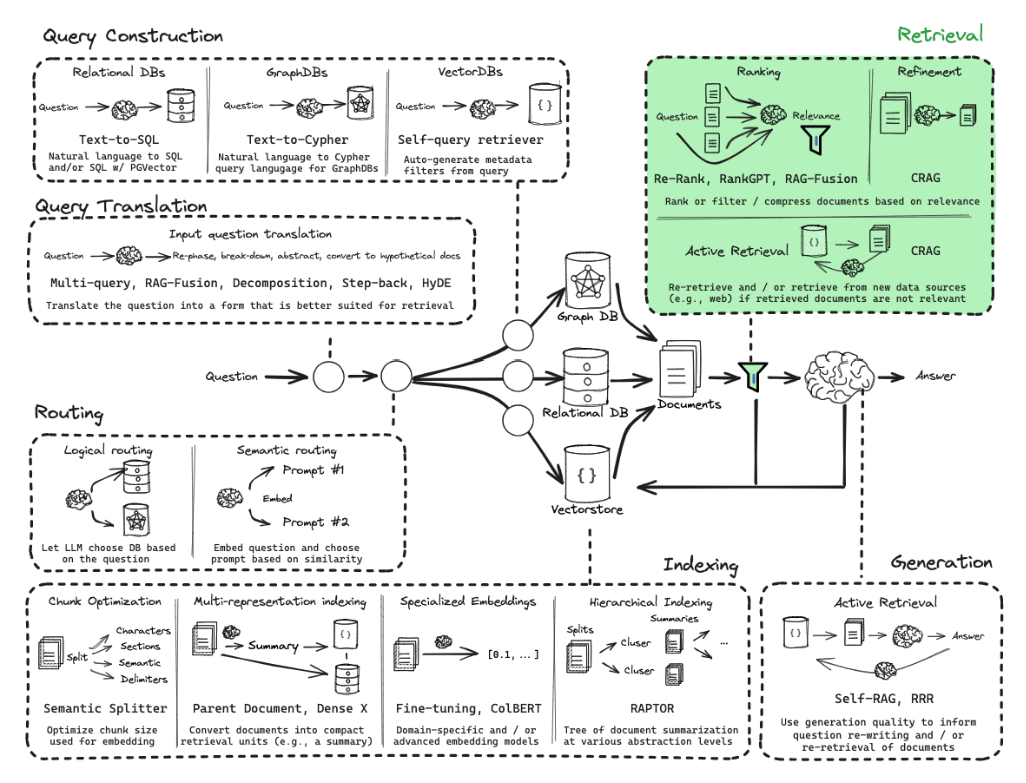

In [ ]:
! pip install langchain_community tiktoken langchain-google-genai langchainhub chromadb langchain cohere

In [2]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = 'LANGCHAIN_API_KEY'
os.environ['GOOGLE_API_KEY']='GOOGLE_API_KEY'
os.environ['COHERE_API_KEY']='COHERE_API_KEY'

# Re-ranking-
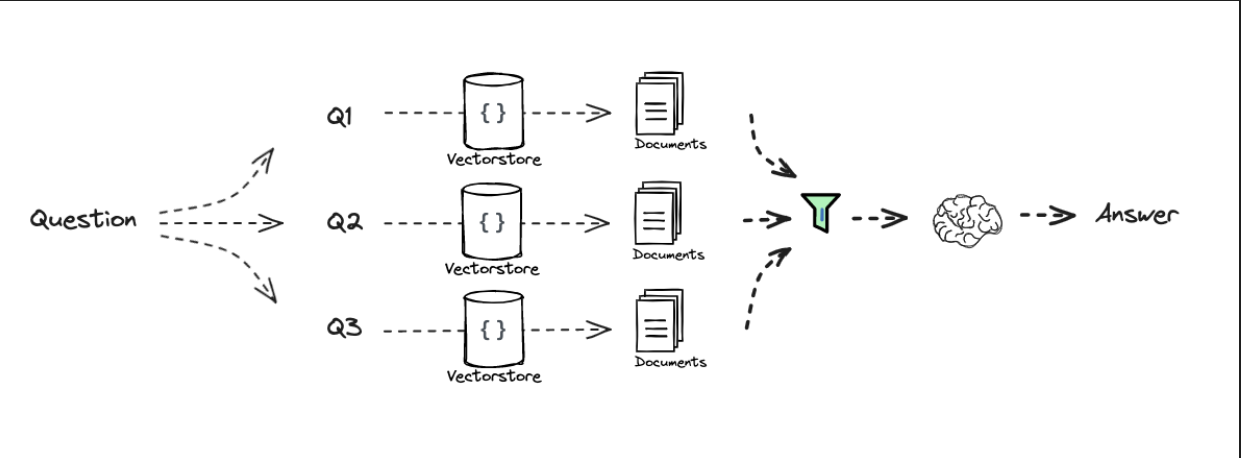

 1. Initial Retrieval
 * A retriever fetches the top N documents based on their similarity to the query.

 2. Reranking Step-
 * A more advanced model(Cohere ranker) re-evaluate the relevance of each retrieved document with respect to the query.

In [5]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Chroma

loader=WebBaseLoader(
    web_path='https://lilianweng.github.io/posts/2023-06-23-agent/',
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(class_=('post-content','post-title','post-header '))
    )
)
blog_docs=loader.load()

# Split
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300,chunk_overlap=50)

# Make splits
splits=text_splitter.split_documents(blog_docs)

# Index
vectorstore=Chroma.from_documents(documents=splits,embedding=GoogleGenerativeAIEmbeddings(model='models/embedding-001'))

retriever=vectorstore.as_retriever()


In [7]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Rag Fusion
template=""" You are a helpful assistant that generate multiple search queries based on sigle input query.\n
          Generate multiple search queries related to: {question}\n
          Output(4 queries):
          """
prompt_rag_fusion=ChatPromptTemplate.from_template(template)

In [8]:
generate_queries=(
    prompt_rag_fusion
    | ChatGoogleGenerativeAI(model='gemini-1.5-flash')
    | StrOutputParser()
    | (lambda x:x.split('\n'))
)

In [9]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents
        and an optional parameter k used in the RRF formula """

    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

question = "What is task decomposition for LLM agents?"
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

<ipython-input-9-460cbb673fbb>:26: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  (loads(doc), score)


5

In [11]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash',temperature=0)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition, in the context of LLM-powered autonomous agents, is the process of breaking down large, complex tasks into smaller, more manageable sub-goals.  This allows the agent to handle complex problems more efficiently.  Methods include using Chain of Thought (CoT) prompting to guide the LLM to think step-by-step, or Tree of Thoughts (ToT) to explore multiple reasoning paths simultaneously.  Task decomposition can be initiated through simple prompts, task-specific instructions, or even human input.'

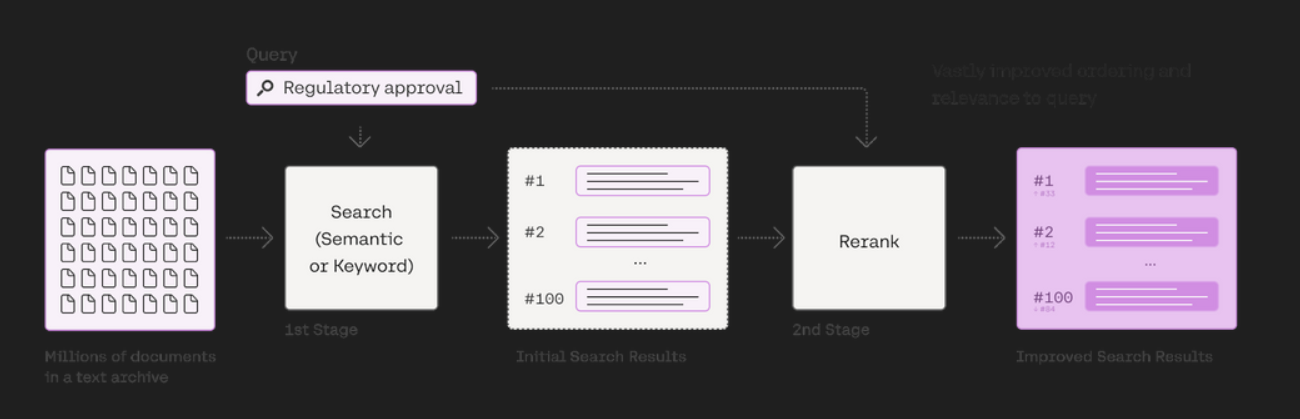

In [ ]:
# Contextual Compression Retriever with a Cohere Reranker,making your document retrieval even more accurate

from langchain_community.llms import Cohere
from langchain.retrievers import  ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank

from langchain.retrievers.document_compressors import CohereRerank

retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

# Re-rank
compressor = CohereRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

compressed_docs = compression_retriever.get_relevant_documents(question)